In [2]:
 #Important imports
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt

#Choosing devide to be gpu if have one, else cpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
tr = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224,0.225]
    )
])

In [5]:
train = ImageFolder(r'D:\GGIT\sigmoid hw\test', transform=tr)
test = ImageFolder(r'D:\GGIT\sigmoid hw\train', transform=tr)

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3= nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.pool3 = nn.MaxPool2d(2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128*28*28, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,1)
        
    def forward(self, x):
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = self.pool3(F.relu(self.conv3(out)))
        
        out = self.flatten(out)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        
        return out

In [7]:
def training_loop(n_epoch, optimizer, model,loss_fn, train_loader, test_loader, print_plot):
    
    train_accuracy = torch.zeros(n_epoch)
    test_accuracy = torch.zeros(n_epoch)
    
    for epoch in range(n_epoch):
        
        for ex, label in train_loader:
            ex = ex.to(DEVICE)
            label = label.to(DEVICE)
            label = label.unsqueeze(1)
            
            output = model(ex.float())
            
            loss  = loss_fn(output, label.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():

            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        print(f'Epoch {epoch+1})', 
          f'Train Accuracy: {train_accuracy[epoch]}',
          f'Test Accuracy: {test_accuracy[epoch]}')
            
    if print_plot:
        
        #Setting x-ticks
        epochs = range(n_epoch)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show() 

In [8]:
train_loader = DataLoader(train, batch_size=32, shuffle=True) #min size if error
test_loader = DataLoader(test, batch_size=32, shuffle=True)

Epoch 1) Train Accuracy: 0.6757575869560242 Test Accuracy: 0.6621160507202148
Epoch 2) Train Accuracy: 0.831818163394928 Test Accuracy: 0.8050815463066101
Epoch 3) Train Accuracy: 0.8378787636756897 Test Accuracy: 0.7830868363380432
Epoch 4) Train Accuracy: 0.8166666626930237 Test Accuracy: 0.7724686861038208
Epoch 5) Train Accuracy: 0.8681818246841431 Test Accuracy: 0.8054607510566711


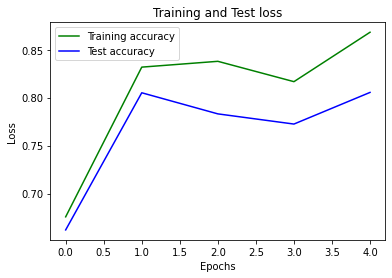

In [9]:
lr = 1e-3

model=Net().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()


training_loop(
    n_epoch =5,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True, 
    train_loader = train_loader, 
    test_loader = test_loader)

In [ ]:
#pretrained

Epoch 1) Train Accuracy: 0.7560606002807617 Test Accuracy: 0.721274197101593
Epoch 2) Train Accuracy: 0.7121211886405945 Test Accuracy: 0.7000378966331482
Epoch 3) Train Accuracy: 0.8484848737716675 Test Accuracy: 0.8244217038154602
Epoch 4) Train Accuracy: 0.846969723701477 Test Accuracy: 0.8240424990653992
Epoch 5) Train Accuracy: 0.8348484635353088 Test Accuracy: 0.8232840299606323


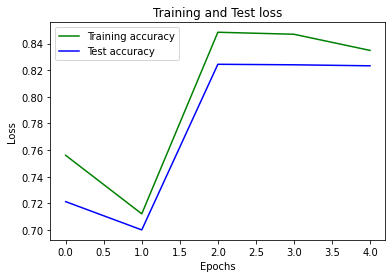

In [10]:
from collections import OrderedDict

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
nr_feat =model.fc.in_features #2048
model.fc = nn.Sequential(OrderedDict([('fc', nn.Linear(nr_feat,1)), ('sigmoid', nn.Sigmoid())]))


#loss_fn = nn.BCEWithLogitsLoss()

lr = 1e-3
model=model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
training_loop(
    n_epoch =5,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True, 
    train_loader = train_loader, 
    test_loader = test_loader)